In [1]:
import tensorflow as tf
from sklearn import model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    MaxPooling2D,
    Conv2D,
    Flatten,
    BatchNormalization,
    Input,
    Average,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import gradio as gr
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import save
from numpy import load

In [2]:
def load_dataset():
    X_train = load("X_GTS_train_copy.npy")
    Y_train = load("Y_GTS_train_copy.npy")
    X_test = load("X_GTS_test_copy.npy")
    Y_test = load("Y_GTS_test_copy.npy")
    string_class_labels = load("Class_labels_copy.npy")
    Y_train = Y_train.astype(np.float)
    Y_test = Y_test.astype(np.float)

    X_train, X_val, Y_train, Y_val = model_selection.train_test_split(
        X_train, Y_train, test_size=0.3, random_state=42, shuffle=True
    )

    return X_train, Y_train, X_test, Y_test, string_class_labels, X_val, Y_val

In [3]:
X_train, Y_train, X_test, Y_test, string_class_labels, X_val, Y_val = load_dataset()

### Image augmentation parameters

In [4]:
datagen = ImageDataGenerator(
    shear_range=0.15,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
)

### Model and training

In [5]:
input_shape = X_train.shape[1:]
model_input = Input(shape=input_shape)

In [6]:
def func_cnn(model_input):

    x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(model_input)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)

    x = Dropout(rate=0.5)(x)

    x = Dense(43, activation="softmax")(x)

    cnn_model = Model(model_input, x, name="conv_pool_cnn")

    return cnn_model

In [7]:
conv_pool_cnn_model = func_cnn(model_input)

In [8]:
def train(model, loss, optimizer, metrics, batch_size, epochs):
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    history = model.fit(
        datagen.flow(X_train, Y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, Y_val),
    )
    return history

In [9]:
history_cnn = train(
    conv_pool_cnn_model, "sparse_categorical_crossentropy", "adam", "accuracy", 32, 30
)

Epoch 1/30
858/858 [==============================] - 17s 12ms/step - loss: 1.3449 - accuracy: 0.6189 - val_loss: 0.4323 - val_accuracy: 0.8605
Epoch 2/30
858/858 [==============================] - 10s 12ms/step - loss: 0.4380 - accuracy: 0.8594 - val_loss: 0.1129 - val_accuracy: 0.9616
Epoch 3/30
858/858 [==============================] - 10s 11ms/step - loss: 0.3054 - accuracy: 0.9009 - val_loss: 0.1419 - val_accuracy: 0.9516
Epoch 4/30
858/858 [==============================] - 10s 11ms/step - loss: 0.2636 - accuracy: 0.9157 - val_loss: 0.1075 - val_accuracy: 0.9634
Epoch 5/30
858/858 [==============================] - 10s 11ms/step - loss: 0.2280 - accuracy: 0.9285 - val_loss: 0.1607 - val_accuracy: 0.9504
Epoch 6/30
858/858 [==============================] - 10s 11ms/step - loss: 0.2041 - accuracy: 0.9354 - val_loss: 0.0750 - val_accuracy: 0.9761
Epoch 7/30
858/858 [==============================] - 10s 12ms/step - loss: 0.1944 - accuracy: 0.9382 - val_loss: 0.0697 - val_accuracy:

### Plotting the loss and the accuracy

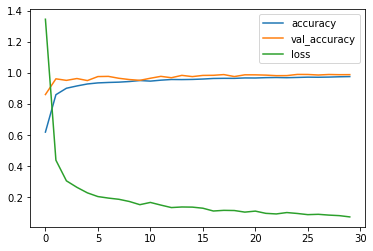

In [10]:
plt.plot(history_cnn.history["accuracy"])
plt.plot(history_cnn.history["val_accuracy"])
plt.plot(history_cnn.history["loss"])
plt.legend(["accuracy", "val_accuracy", "loss"])

In [11]:
conv_pool_cnn_model.summary()

Model: "conv_pool_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)     

In [12]:
score_cnn = conv_pool_cnn_model.evaluate(X_test, Y_test)

395/395 [==============================] - 1s 2ms/step - loss: 0.2422 - accuracy: 0.9465


### Calculating log loss for CNN model

In [13]:
pred_Cnn = conv_pool_cnn_model.predict(X_test)

In [14]:
log_loss_score = metrics.log_loss(Y_test, pred_Cnn)
print("Log loss score: {}".format(log_loss_score))

Log loss score: 0.242151899069741


### Confusion matrix

In [15]:
classes_x = np.argmax(pred_Cnn, axis=1)

In [16]:
cf = confusion_matrix(Y_test, classes_x)

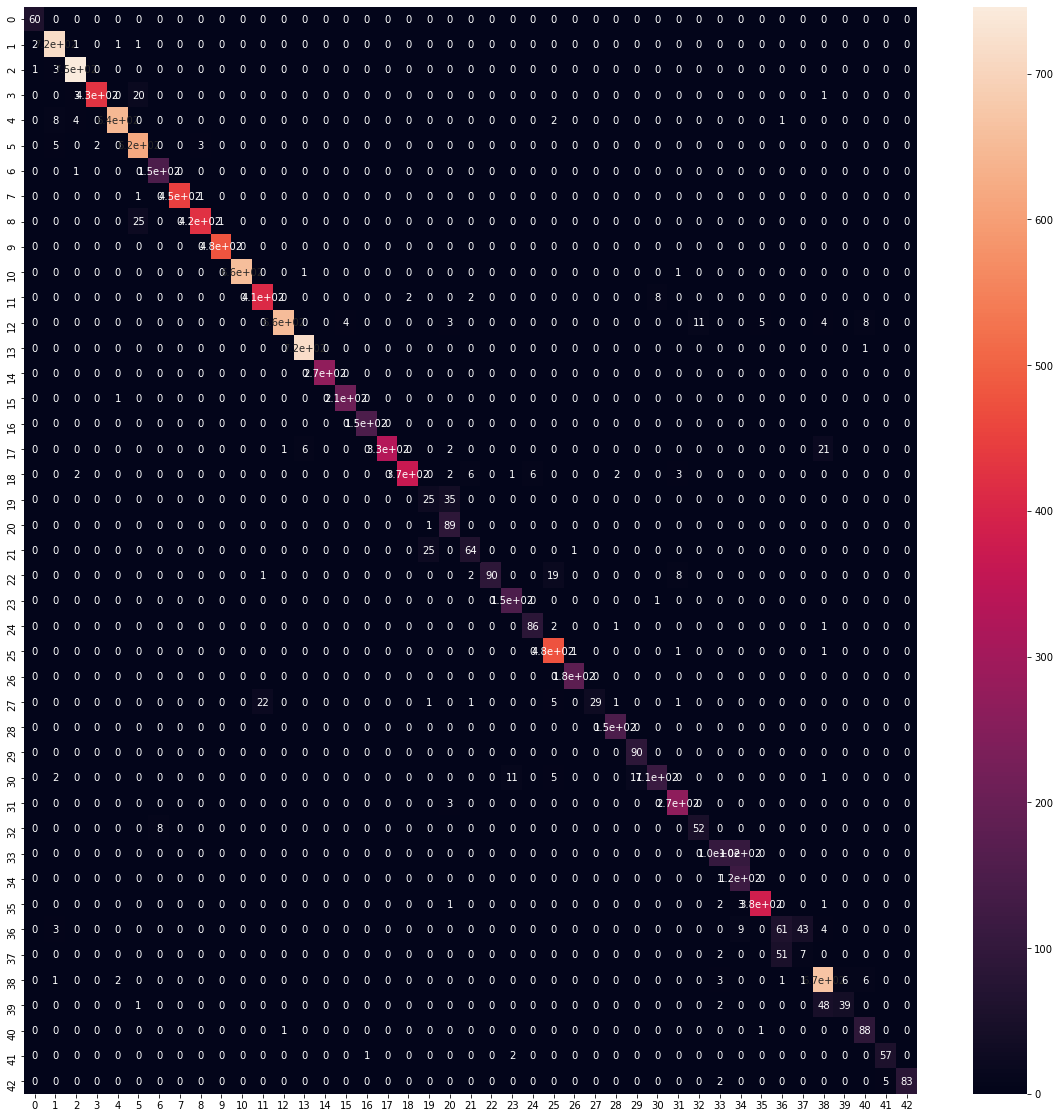

In [17]:
df_cm = pd.DataFrame(cf, index=string_class_labels, columns=string_class_labels)
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True)

### Classification report

In [18]:
print(classification_report(Y_test, classes_x))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        60
         1.0       0.97      0.99      0.98       720
         2.0       0.99      0.99      0.99       750
         3.0       1.00      0.95      0.97       450
         4.0       0.99      0.98      0.99       660
         5.0       0.93      0.98      0.96       630
         6.0       0.95      0.99      0.97       150
         7.0       1.00      1.00      1.00       450
         8.0       0.99      0.94      0.97       450
         9.0       1.00      1.00      1.00       480
        10.0       1.00      1.00      1.00       660
        11.0       0.95      0.97      0.96       420
        12.0       1.00      0.95      0.97       690
        13.0       0.99      1.00      0.99       720
        14.0       1.00      1.00      1.00       270
        15.0       0.98      1.00      0.99       210
        16.0       0.99      1.00      1.00       150
        17.0       1.00    

## Using transfer learning on VGG19

In [19]:
def func_transfer(model_input):

    vgg19_model = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_tensor=model_input,
        pooling=max,
        classes=43,
        classifier_activation="softmax",
    )

    for layer in vgg19_model.layers:
        layer.trainable = True

    x = BatchNormalization()(vgg19_model.output)
    x = Flatten()(x)
    x = Dense(1024, activation="sigmoid")(x)

    x = Dense(43, activation="softmax")(x)

    vg_model = Model(inputs=model_input, outputs=x, name="vgg19_transfer")

    return vg_model

In [20]:
vgg19_transfer_model = func_transfer(model_input)

In [21]:
history_vg = train(
    vgg19_transfer_model, "sparse_categorical_crossentropy", "adam", "accuracy", 32, 30
)

Epoch 1/30
858/858 [==============================] - 21s 23ms/step - loss: 2.9076 - accuracy: 0.1457 - val_loss: 2.2921 - val_accuracy: 0.2217
Epoch 2/30
858/858 [==============================] - 19s 22ms/step - loss: 2.3867 - accuracy: 0.2197 - val_loss: 2.4504 - val_accuracy: 0.1690
Epoch 3/30
858/858 [==============================] - 19s 22ms/step - loss: 2.2182 - accuracy: 0.2486 - val_loss: 2.1809 - val_accuracy: 0.2379
Epoch 4/30
858/858 [==============================] - 19s 22ms/step - loss: 2.2006 - accuracy: 0.2540 - val_loss: 5.6274 - val_accuracy: 0.0699
Epoch 5/30
858/858 [==============================] - 20s 23ms/step - loss: 2.1404 - accuracy: 0.2626 - val_loss: 2.2160 - val_accuracy: 0.2344
Epoch 6/30
858/858 [==============================] - 20s 23ms/step - loss: 2.0341 - accuracy: 0.2878 - val_loss: 2.4939 - val_accuracy: 0.1732
Epoch 7/30
858/858 [==============================] - 19s 23ms/step - loss: 1.6968 - accuracy: 0.3876 - val_loss: 1.3765 - val_accuracy:

In [22]:
vgg19_transfer_model.summary()

Model: "vgg19_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)      

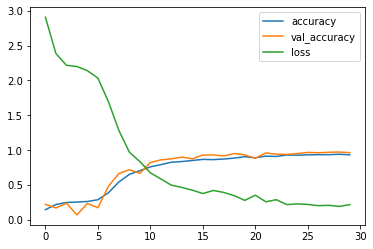

In [23]:
plt.plot(history_vg.history["accuracy"])
plt.plot(history_vg.history["val_accuracy"])
plt.plot(history_vg.history["loss"])
plt.legend(["accuracy", "val_accuracy", "loss"])

In [24]:
score_vg = vgg19_transfer_model.evaluate(X_test, Y_test)

395/395 [==============================] - 2s 6ms/step - loss: 0.3444 - accuracy: 0.9255


### Log loss for vgg19 transfer architecture model

In [25]:
pred_vg = vgg19_transfer_model.predict(X_test)

In [26]:
log_loss_score_vg = metrics.log_loss(Y_test, pred_vg)
print("Log loss score: {}".format(log_loss_score_vg))

Log loss score: 0.3427089769729845


### Confusion matrix for vgg19 model

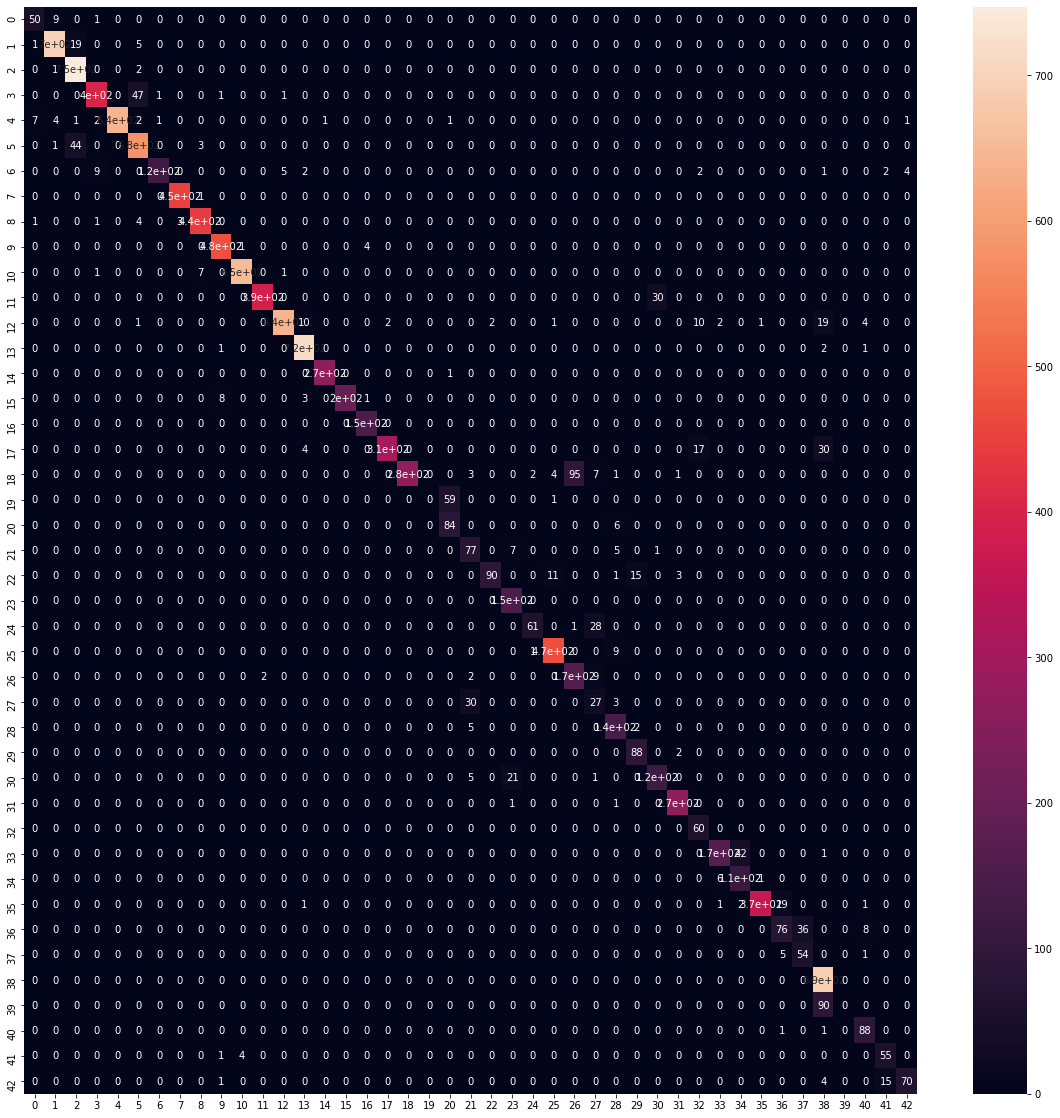

In [27]:
classes_x_vg = np.argmax(pred_vg, axis=1)
cf_vg = confusion_matrix(Y_test, classes_x_vg)

df_cm_vg = pd.DataFrame(cf_vg, index=string_class_labels, columns=string_class_labels)
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm_vg, annot=True)

### Classification report

In [28]:
print(classification_report(Y_test, classes_x_vg))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84        60
         1.0       0.98      0.97      0.97       720
         2.0       0.92      1.00      0.96       750
         3.0       0.97      0.89      0.93       450
         4.0       1.00      0.97      0.98       660
         5.0       0.91      0.92      0.91       630
         6.0       0.98      0.83      0.90       150
         7.0       0.99      1.00      1.00       450
         8.0       0.98      0.98      0.98       450
         9.0       0.98      0.99      0.98       480
        10.0       0.99      0.99      0.99       660
        11.0       0.99      0.93      0.96       420
        12.0       0.99      0.92      0.96       690
        13.0       0.97      0.99      0.98       720
        14.0       1.00      1.00      1.00       270
        15.0       1.00      0.94      0.97       210
        16.0       0.97      1.00      0.98       150
        17.0       0.99    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Average ensemble model

In [31]:
def ensemble_model(model_1, model_2):
    models_list = []
    models_list.append(model_1)
    models_list.append(model_2)

    model_output_list = [model(model_input) for model in models_list]
    ensemble_output = tf.keras.layers.Average()(model_output_list)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

    return ensemble_model

In [32]:
ensemble_model = ensemble_model(conv_pool_cnn_model, vgg19_transfer_model)

In [33]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_pool_cnn (Functional)      (None, 43)           1759051     input_1[0][0]                    
__________________________________________________________________________________________________
vgg19_transfer (Functional)     (None, 43)           20595819    input_1[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 43)           0           conv_pool_cnn[1][0]              
                                                                 vgg19_transfer[1][0]         

### Training

In [34]:
history_ensemble = train(
    ensemble_model, "sparse_categorical_crossentropy", "adam", "accuracy", 32, 30
)

Epoch 1/30
858/858 [==============================] - 22s 25ms/step - loss: 0.0991 - accuracy: 0.9765 - val_loss: 0.0897 - val_accuracy: 0.9846
Epoch 2/30
858/858 [==============================] - 21s 24ms/step - loss: 0.1125 - accuracy: 0.9751 - val_loss: 0.1005 - val_accuracy: 0.9858
Epoch 3/30
858/858 [==============================] - 21s 24ms/step - loss: 0.1104 - accuracy: 0.9759 - val_loss: 0.0759 - val_accuracy: 0.9814
Epoch 4/30
858/858 [==============================] - 21s 24ms/step - loss: 0.0961 - accuracy: 0.9774 - val_loss: 0.0506 - val_accuracy: 0.9909
Epoch 5/30
858/858 [==============================] - 21s 24ms/step - loss: 0.1130 - accuracy: 0.9738 - val_loss: 0.0602 - val_accuracy: 0.9880
Epoch 6/30
858/858 [==============================] - 21s 24ms/step - loss: 0.1022 - accuracy: 0.9765 - val_loss: 0.0521 - val_accuracy: 0.9884
Epoch 7/30
858/858 [==============================] - 20s 24ms/step - loss: 0.1157 - accuracy: 0.9739 - val_loss: 0.0988 - val_accuracy:

### Evaluate and predict on test set

In [35]:
score_ensemble = ensemble_model.evaluate(X_test, Y_test)

395/395 [==============================] - 3s 7ms/step - loss: 0.2191 - accuracy: 0.9519


In [36]:
pred_ens = ensemble_model.predict(X_test)

### Log loss

In [37]:
log_loss_score_ens = metrics.log_loss(Y_test, pred_ens)
print("Log loss score: {}".format(log_loss_score_ens))

Log loss score: 0.22207731239115464


### Soft voting

In [38]:
### Here we predict the output based on the max probability for each class label obtained by combining the outputs of the CNN and the VG16 based model

softvoting = pred_vg + pred_Cnn
log_loss_softvoting = metrics.log_loss(Y_test, softvoting)
print("Log loss score: {}".format(log_loss_softvoting))

Log loss score: 0.19205694852732097
